# Ranking school examination results using multivariate hierarchical models

In [1]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt

In [2]:
import json 

with open("data/data.json") as file:
    data = json.load(file)
    
with open("data/init.json") as file:
    init = json.load(file)
    
with open("data/params.json") as file:
    params = json.load(file)

In [3]:
for idx, item in data.items():
    data[idx] = np.array(item).reshape(-1)

for idx, item in init.items():
    init[idx] = np.array(item).reshape(-1)
    
for idx, item in params.items():
    params[idx] = np.array(item).reshape(-1)

In [4]:
data.keys(), init.keys(), params.keys()

(dict_keys(['Gender', 'LRT', 'M', 'N', 'R', 'school', 'School_denom', 'School_gender', 'Y', 'VR']),
 dict_keys(['theta', 'phi', 'gamma', 'beta', 'Omega', 'alpha']),
 dict_keys(['R_shape', 'School_denom_shape', 'School_gender_shape', 'Venom_shape', 'Omega_shape', 'alpha_shape']))

In [109]:
hyperparams = dict()
hyperparams["tau0"] = 1e-3
hyperparams["sd_proposal"] = 1

In [112]:
def sampler(n, data, init, params, hyperparams):
    
    # initialisation de la chaine 
    chain = dict()
    for key, param in init.items():
        chain[key] = np.zeros((n+1, param.shape[0]))
        chain[key][0, :] = param
    
    # définition des constantes
    Y = data["Y"]
    
    N   = Y.shape[0]
    n_beta = init["beta"].shape[0]
    n_schools = np.max(data["school"])
    
    LRT_sum = np.sum(data["LRT"])
    tau0 = hyperparams["tau0"]
    sd_proposal = hyperparams["sd_proposal"]
    
    T0 = np.linalg.inv(init["Omega"].reshape(3, 3))
    R_inv = np.linalg.inv(data["R"].reshape(3, 3))
    alpha_idx = np.arange(init["alpha"].shape[0])
    
    # définition de v
    LRT = data["LRT"].reshape(-1, 1)
    VR = data["VR"].reshape(N, -1, order="F")
    Girl = data["Gender"].reshape(-1, 1)
    School_gender = data["School_gender"].reshape(N, -1, order="F")
    School_denom = data["School_denom"].reshape(N, -1, order="F")

    v = np.concatenate((LRT**2, VR[:, [1]], Girl , School_gender, School_denom), axis=1)
    
    # définition de u
    u = np.concatenate((np.ones((N, 1)), LRT, VR[:, [1]]), axis=1)
    
    # initialisation de mu et tau
    mu  = np.zeros(N) 
    
    # mise à jour des paramètres
    for i in range(1, n+1):
        # calcul de mu
        alpha_current = chain["alpha"][i-1, :]
        beta_current = chain["beta"][i-1, :].reshape(1, -1)
        for k in range(N):
            j = data["school"][k]
            alpha_j = alpha_current[(3*(j-1)):(3*j)].reshape(1, -1)
            mu[k] = np.dot(alpha_j, u[[k], :].T) + np.dot(beta_current, v[[k], :].T)
        beta_current = beta_current.flatten()
        
        # calcul de tau
        theta_current = chain["theta"][i-1, :]
        phi_current = chain["phi"][i-1, :]        
        tau = np.exp(theta_current + phi_current * LRT).flatten()
    
        # mise à jour de phi: mcmc 
        # phi peut prendre toutes les valeurs réelles, 
        # donc on utilise le "random walk M.-H. scheme"
        phi_proposal = phi_current + np.random.normal(scale=sd_proposal)
        
        phi_top = (-tau0/2) * np.power(phi_proposal, 2)
        phi_top += (LRT_sum/2) * phi_proposal
        phi_top -= (np.exp(theta_current)/2) * np.sum(
            np.exp(phi_proposal*data["LRT"]) * np.power(data["Y"]-mu, 2)
        )
    
        phi_bottom = (-tau0/2) * np.power(phi_current, 2)
        phi_bottom += (LRT_sum/2) * phi_current
        phi_bottom -= (np.exp(theta_current)/2) * np.sum(
            np.exp(phi_current*data["LRT"]) * np.power(data["Y"]-mu, 2)
        )
        
        phi_acceptance = np.exp(phi_top-phi_bottom)
        if phi_acceptance < np.random.rand():
            chain["phi"][i,:] = phi_proposal
            phi_current = phi_proposal
        else:
            chain["phi"][i,:] = phi_current

        # mise à jour de theta: mcmc 
        # theta peut prendre toutes les valeurs réelles, 
        # donc on utilise le "random walk M.-H. scheme"        
        theta_proposal = theta_current + np.random.normal(scale=sd_proposal)
        
        theta_top = (-tau0/2) * np.power(theta_proposal, 2)
        theta_top += (N/2) * theta_proposal
        theta_top -= (np.exp(theta_proposal)/2) * np.sum(
            np.exp(phi_current*data["LRT"]) * np.power(data["Y"]-mu, 2)
        )
        
        theta_bottom = (-tau0/2) * np.power(theta_current, 2)
        theta_bottom += (LRT_sum/2) * theta_current
        theta_bottom -= (np.exp(theta_current)/2) * np.sum(
            np.exp(phi_current*data["LRT"]) * np.power(data["Y"]-mu, 2)
        ) 
        
        theta_acceptance = np.exp(theta_top-theta_bottom)
        if theta_acceptance < np.random.rand():
            chain["theta"][i,:] = theta_proposal
            theta_current = theta_proposal
        else:
            chain["theta"][i,:] = theta_current
                      
        # mise à jour de beta: normale multivariée        
        beta_cov_inv = tau0 * np.eye(n_beta) 
        for k in range(N):
            beta_cov_inv = beta_cov_inv + tau[k] * np.dot(v[[k], :].T, v[[k], :])
        beta_cov = np.linalg.inv(beta_cov_inv)
        
        beta_mean = np.sum(tau * Y * v.T, axis=1, keepdims=True)
        for j in range(1, n_schools+1):
            school_j = (data["school"] ==j)
            alpha_j = alpha_current[(3*(j-1)):(3*j)].reshape(1, -1)
            beta_mean = beta_mean - np.dot(alpha_j, np.dot(u[school_j, :].T, v[school_j, :])).T
        beta_mean = np.dot(beta_cov, beta_mean).flatten()
        
        beta_proposal = np.random.multivariate_normal(beta_mean, beta_cov)
        
        chain["beta"][i, :] = beta_proposal
        beta_current = beta_proposal
        
        # mise à jour de gamma: normale
        print(chain["Omega"][i-1, :].flatten())
        T_current = np.linalg.inv(chain["Omega"][i-1, :].reshape(3, 3))
        
        
        alpha_current_sum = np.zeros(3)
        for j in range(1, n_schools+1):
            alpha_current_sum = alpha_current_sum + alpha_current[(3*(j-1)):(3*j)]
        alpha_current_sum = alpha_current_sum.reshape(-1, 1)
        
        gamma_cov = np.linalg.inv(T0+n_schools*T_current)
        gamma_mean = np.dot(gamma_cov, np.dot(T_current, alpha_current_sum))
        gamma_mean = gamma_mean.flatten()
        
        gamma_proposal = np.random.multivariate_normal(gamma_mean, gamma_cov)
        
        chain["gamma"][i, :] = gamma_proposal
        gamma_current = gamma_proposal
        
        # mise à jour de alpha: normale
        beta_current = beta_current.reshape(1, -1)
        for j in range(1, n_schools+1):
            school_j = (data["school"] == j)
            tau_j = tau[school_j]
            u_j = u[school_j, :]
            v_j = v[school_j, :]
            Y_j = Y[school_j]
            
            n_j = len(Y_j)
            alphaj_cov = T_current
            for k in range(n_j):
                u_kj =  u[[k], :]
                alphaj_cov = alphaj_cov + tau_j[k] * np.dot(u_kj.T, u_kj)
            
            alphaj_mean = np.dot(T_current, gamma_current.reshape(-1,1)).reshape(1,-1)
            for k in range(n_j):
                alphaj_mean = alphaj_mean + tau_j[k] * (Y_j[k] - np.dot(beta_current, v_j[[k], :].T)) * u[[k], :]
            alphaj_mean = alphaj_mean.flatten()
            
            alphaj_proposal = np.random.multivariate_normal(alphaj_mean, alphaj_cov)
            chain["alpha"][i,(3*(j-1)):(3*j)] = alphaj_proposal
        
        alpha_current = chain["alpha"][i, :]
        
        # mise à jour de T=inverse de Omega: mcmc       
        Omega_current = chain["Omega"][i-1, :].reshape(3, 3)
        gamma_current = gamma_current.reshape(-1, 1)
        
        for (m, n) in ((0,0), (0,1), (0,2), (1,1), (1,2), (2,2)):
            while True:
                try:
                    Tmn =  np.random.normal(T_current[m, n], scale=sd_proposal)

                    T_proposal = np.copy(T_current)
                    T_proposal[m, n] = Tmn
                    T_proposal[n, m] = Tmn

                    Omega_proposal =  np.linalg.inv(T_proposal)
                except LinAlgError:
                    continue
                else:
                    break
            
            T_top = ((n_schools-1)/2) * np.log(np.linalg.det(T_proposal+ 1e-3 * np.eye(3)))
            T_top -= .5 * np.sum(np.diag(np.dot(R_inv, T_proposal))) 

            T_bottom = ((n_schools-1)/2) * np.log(np.linalg.det(T_current + 1e-3 * np.eye(3)))
            T_bottom -= .5 * np.sum(np.diag(np.dot(R_inv, T_current))) 

            for j in range(1, n_schools+1):
                alpha_j = alpha_current[(3*(j-1)):(3*j)].reshape(-1, 1)
                diff_j = gamma_current - alpha_j
                T_top -= .5 * np.dot(diff_j.T, np.dot(T_proposal, diff_j))
                T_bottom -= .5 * np.dot(diff_j.T, np.dot(T_current, diff_j))
            
            T_acceptance = np.exp(T_top - T_bottom)
            print(T_acceptance.shape)
            print(T_acceptance, T_top, T_bottom)
            if T_acceptance < np.random.rand():
                chain["Omega"][i, :] = Omega_proposal.flatten()
                T_current = T_proposal
                Omega_current = Omega_proposal
            else:
                chain["Omega"][i, :] = Omega_current.flatten()
        
    return chain

In [113]:
chain = sampler(50, data, init, params, hyperparams)

/tmp/ipykernel_6925/635463268.py:96: RuntimeWarning: overflow encountered in exp
  theta_acceptance = np.exp(theta_top-theta_bottom)
/tmp/ipykernel_6925/635463268.py:184: RuntimeWarning: invalid value encountered in log
  T_top = ((n_schools-1)/2) * np.log(np.linalg.det(T_proposal+ 1e-3 * np.eye(3)))
/tmp/ipykernel_6925/635463268.py:72: RuntimeWarning: overflow encountered in exp
  phi_acceptance = np.exp(phi_top-phi_bottom)
/tmp/ipykernel_6925/635463268.py:196: RuntimeWarning: overflow encountered in exp
  T_acceptance = np.exp(T_top - T_bottom)


[ 10.  -3.  -3.  -3. 135. -65.  -3. -65. 135.]
(1, 1)
[[nan]] [[nan]] [[-2941.33137865]]
(1, 1)
[[nan]] [[nan]] [[-2941.33137865]]
(1, 1)
[[nan]] [[nan]] [[-2941.33137865]]
(1, 1)
[[0.]] [[-148115.61417273]] [[-2941.33137865]]
(1, 1)
[[nan]] [[nan]] [[-148115.61417273]]
(1, 1)
[[0.]] [[-149342.02119479]] [[-148115.61417273]]
[ 9.74861003 -0.06996594 -0.06426814 -0.06996594  1.64407277 -0.01153409
 -0.06426814 -0.01153409  1.51112403]
(1, 1)
[[nan]] [[nan]] [[-5.69155728e+10]]
(1, 1)
[[0.]] [[-5.74752495e+10]] [[-5.69155728e+10]]
(1, 1)
[[nan]] [[nan]] [[-5.74752495e+10]]
(1, 1)
[[nan]] [[nan]] [[-5.74752495e+10]]
(1, 1)
[[inf]] [[-5.57357925e+10]] [[-5.74752495e+10]]
(1, 1)
[[inf]] [[-5.72827027e+10]] [[-5.74752495e+10]]
[10.88683024  1.44750589 -0.08290656  1.44750589  1.83603006 -0.02301854
 -0.08290656 -0.02301854  1.5113317 ]
(1, 1)
[[nan]] [[nan]] [[-4.17052063e+15]]
(1, 1)
[[inf]] [[-3.79529783e+15]] [[-4.17052063e+15]]
(1, 1)
[[0.]] [[-4.23493424e+15]] [[-4.17052063e+15]]
(1, 1)

/tmp/ipykernel_6925/635463268.py:160: RuntimeWarning: covariance is not positive-semidefinite.
  alphaj_proposal = np.random.multivariate_normal(alphaj_mean, alphaj_cov)


(1, 1)
[[nan]] [[nan]] [[-1.42541104e+122]]
(1, 1)
[[inf]] [[-1.39422243e+122]] [[-1.42541104e+122]]
(1, 1)
[[nan]] [[nan]] [[-1.42541104e+122]]
(1, 1)
[[0.]] [[-3.02496368e+122]] [[-1.42541104e+122]]
(1, 1)
[[nan]] [[nan]] [[-3.02496368e+122]]
(1, 1)
[[inf]] [[-3.00359596e+122]] [[-3.02496368e+122]]
[ 7.87073722  0.33368245 -0.758465    0.33368245  0.69762967  0.02236481
 -0.758465    0.02236481  0.49985024]
(1, 1)
[[0.]] [[-7.52647976e+140]] [[-7.43699378e+140]]
(1, 1)
[[inf]] [[-7.50109367e+140]] [[-7.52647976e+140]]
(1, 1)
[[nan]] [[nan]] [[-7.52647976e+140]]
(1, 1)
[[0.]] [[-9.33120352e+140]] [[-7.52647976e+140]]
(1, 1)
[[0.]] [[-9.81973124e+140]] [[-9.33120352e+140]]
(1, 1)
[[inf]] [[-9.8194168e+140]] [[-9.81973124e+140]]
[ 2.0787628  -0.57968427 -0.66812821 -0.57968427  2.77183834  2.26109333
 -0.66812821  2.26109333  2.28634734]
(1, 1)
[[nan]] [[nan]] [[-1.74861941e+181]]
(1, 1)
[[nan]] [[nan]] [[-1.74861941e+181]]
(1, 1)
[[inf]] [[-1.71464164e+181]] [[-1.74861941e+181]]
(1, 1)

/tmp/ipykernel_6925/635463268.py:63: RuntimeWarning: overflow encountered in multiply
  np.exp(phi_proposal*data["LRT"]) * np.power(data["Y"]-mu, 2)
/tmp/ipykernel_6925/635463268.py:87: RuntimeWarning: overflow encountered in multiply
  np.exp(phi_current*data["LRT"]) * np.power(data["Y"]-mu, 2)
/tmp/ipykernel_6925/635463268.py:93: RuntimeWarning: overflow encountered in multiply
  np.exp(phi_current*data["LRT"]) * np.power(data["Y"]-mu, 2)
/tmp/ipykernel_6925/635463268.py:96: RuntimeWarning: invalid value encountered in subtract
  theta_acceptance = np.exp(theta_top-theta_bottom)
/tmp/ipykernel_6925/635463268.py:69: RuntimeWarning: overflow encountered in multiply
  np.exp(phi_current*data["LRT"]) * np.power(data["Y"]-mu, 2)
/tmp/ipykernel_6925/635463268.py:72: RuntimeWarning: invalid value encountered in subtract
  phi_acceptance = np.exp(phi_top-phi_bottom)


LinAlgError: Singular matrix

In [83]:
chain

{'theta': array([[0.        ],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
        [2.88947795],
 

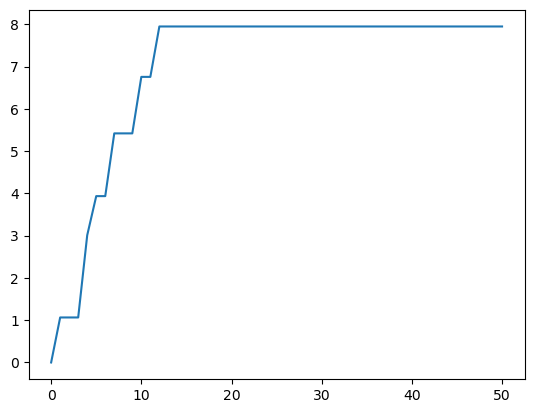

In [54]:
plt.plot(chain["theta"])